# Environment setup

In [1]:
# Import libraries

# For reading, handling data and calculations
import os
import numpy as np
from collections import defaultdict

# For displaying images, plotting metrics, etc.
from matplotlib import pyplot as plt
import seaborn as sns

# For splitting samples into training and testing
from sklearn.model_selection import train_test_split

# PyTorch modules for building, training, and evaluating neural networks
import torch
from torch import Generator
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Sampler, WeightedRandomSampler

# Torchvision modules for computer vison and image handling
import torchvision
from torchvision import datasets, transforms

# Metrics for evaluating model performance
import torchmetrics

# For displaying commands in each cell
from IPython.core.interactiveshell import InteractiveShell

# tqdm allows us to display a progress bar for long loops
from tqdm import tqdm 

In [2]:
# Display output of every command in a cell
InteractiveShell.ast_node_interactivity = 'all'

# Progress bar for pandas
tqdm.pandas()

# Random seed generator for pytorch
SEED = 42

# Set plotting style
sns.set_style('darkgrid')

# Device on which to train model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Read Data

In [3]:
# Root path to all images and
ROOT_PATH = '/kaggle/input/animals10/raw-img/'

# Path for all outputs
OUT_PATH = '/kaggle/working/'

# Since animal names are in italian we will have to translate into English
translate = {'cane': 'Dog', 
             'cavallo': 'Horse', 
             'elefante': 'Elephant', 
             'farfalla': 'Butterfly', 
             'gallina': 'Chicken', 
             'gatto': 'Cat', 
             'mucca': 'Cow', 
             'pecora': 'Sheep', 
             'ragno': 'Spider', 
             'scoiattolo': 'Squirrel'
            }

As we observed when exploring the dataset in module 1, there is a large imbalance in the animal classes. This will bias the model we train and will likely lead to a model that always predicts dogs or spiders as these two classes account for almost half the images. To overcome this, we will *oversample* the minority classes when training such that there is a balanced representation of each class. This requires that some images in the minority classes will pass through the model more than once during training, which can lead to overfitting, but by augmenting the images (e.g., flipping or rotating an image) we can introduce variability into the model and reduce any overfitting. We will have to build a custom dataloader to handle all of this.

In [4]:
# Functions we need to produced class-balanced samples of our dataset

def balanced_class_weights(targets: list[int], subset_idx: list[int]) -> list[float]:
    '''Return the per-class weights needed to balance the class distributions.
    
    Each class's weight is defined as the reciprical of the class's count in the subset.
    When data are sampled from each subset with these weights, the class distribution will
    be approximately balanced for a sufficiently large sample.
    '''
    subset_idx = set(subset_idx)
    class_counts = defaultdict(int)
    for idx, target in enumerate(targets):
        if idx in subset_idx:
            class_counts[target] += 1
            
    weights = [1./count for _, count in sorted(class_counts.items())]
    return weights

def balanced_sample_weights(targets: list[int], subset_idx: list[int]) -> list[float]:
    '''Return the per-sample weights needed to balance the class distributions.
    
    Every element in the dataset will be assigned its corresponding class weight for the subset.
    Elements in the dataset outside of the subset will be assigned a weight of zero, 
    so those elements will not be sampled when the weights are passed to a sampler.
    '''
    
    # Get the weights for each class
    weights = balanced_class_weights(targets, subset_idx)
    
    # Assign the corresponding class weight to each target index in the subset 
    # and a weight of zero to target indices outside of the subset
    subset_idx = set(subset_idx)
    sample_weights = [0]*len(targets)
    for idx, target in enumerate(targets):
        if idx in subset_idx:
            sample_weights[idx] = weights[target]
            
    return sample_weights

def balanced_sampler(targets: list[int], subset_idx: list[int], num_samples: int, generator: Generator) -> Sampler[int]:
    '''Returns a random sampler weighted to balance the classes within the subset.'''
    
    # We will sample images based on the inverse of their class frequency in the subset to balance the representation of each class
    weights = balanced_sample_weights(targets, subset_idx)
    
    # The sampler will tell the dataloader to randomly sample images according to the weights we defined;
    # Images in the minority classes will be sampled more frequently than from majority classes
    sampler = WeightedRandomSampler(weights, 
                                    num_samples=num_samples,
                                    replacement=True, 
                                    generator=generator
                                   )
    return sampler

In [5]:
IMAGE_SIZE = 300
TRAIN_SPLIT = 0.8
BATCH_SIZE = 16

# Define transforms
my_transforms = transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(IMAGE_SIZE),
                                    transforms.CenterCrop(IMAGE_SIZE)
                                   ])
# Read data from root directory
dataset = datasets.ImageFolder(root=ROOT_PATH, transform=my_transforms)

# Split the dataset into training and testing subsets; return indices of subsets
train_idx, test_idx = train_test_split(np.arange(len(dataset.targets)), 
                                       train_size=TRAIN_SPLIT,  
                                       random_state=SEED, 
                                       shuffle=True, 
                                       stratify=dataset.targets
                                      )

# Samplers to oversample the train or test set such that the classes are balanced
train_sampler = balanced_sampler(dataset.targets,
                                 subset_idx=train_idx,
                                 num_samples=len(train_idx),
                                 generator=Generator('cpu').manual_seed(SEED)
                                )

test_sampler = balanced_sampler(dataset.targets,
                                subset_idx=test_idx,
                                num_samples=len(test_idx),
                                generator=Generator('cpu').manual_seed(SEED)
                               )

# Dataloaders to sample each train/test subset in batches
train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [6]:
test_target_counts = []
for minibatch, (imgs, labels) in tqdm(enumerate(test_loader)):
    for target_label in labels.tolist():
        test_target_counts.append(target_label)

328it [00:40,  8.05it/s]


(array([499., 572., 526., 522., 517., 528., 512., 512., 524., 524.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

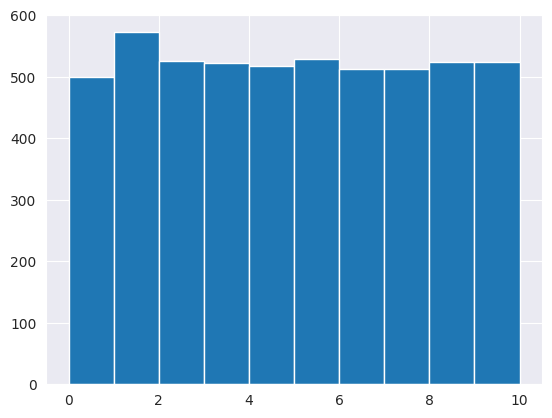

In [7]:
plt.hist(test_target_counts, bins=10, range=[0,10])

In [8]:
train_target_counts = []
for minibatch, (imgs, labels) in tqdm(enumerate(train_loader)):
    for target_label in labels.tolist():
        train_target_counts.append(target_label)

1309it [02:19,  9.36it/s]


(array([2048., 2137., 2059., 2116., 2104., 2091., 2085., 2081., 2069.,
        2153.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

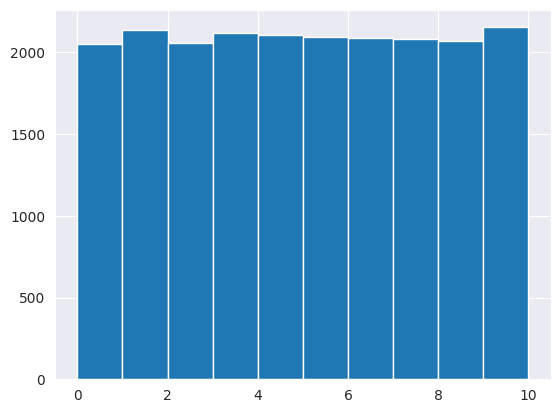

In [9]:
plt.hist(train_target_counts, bins=10, range=[0,10])

As we can see from the histograms of the training and testing sets, the classes are now approximately balanced by oversampling the minority classes.

# Building the Neural Network

Now we will build the model and specify the hyperparameters. 

The model we will use is a Convolutional Neural Network (CNN). Our model will subclass `Module` from the `torch` library and consist of:

* One convolution layer with a 12 x 12 kernel and a stride of 1
* One 2 x 2 pooling layer with 6 features
* A second convolution layer with a 12 x 12 kernel and a stride of 1
* A second 2 x 2 pooling layer with 12 features
* Three fully-connected layers with sizes: 100 x 50, 50 x 20, and 20 x 10
* All convolution and fully-connected layer logits are passed through the ReLu activation function
* The final 1 x 10 dimensional output layer is passed through the softmax function

In [10]:
# Now build the image classifier with a Convolutional Neural Network (CNN)

class ImageClassifier(nn.Module):
    '''Convolutional Neural Network for classifying images into 1 of 10 classes.'''
    
    def __init__(self):
        '''Initialize the CNN and define the layers.'''
        super().__init__()
        
        # Input -> 3 x 300 x 300 (RBG channels, pixel height, pixel width)
        
        self.conv1 = nn.Conv2d(3, 6, 5) 
        
        # Conv1 -> 6 x 296 x 296 : where ((300 - 5)/1) + 1 = 296
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # Pool1 -> 6 x 148 x 148 : where ((296 - 2)/2) + 1 = 148
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Conv2 -> 16 x 144 x 144 : where ((144 - 5)/1) + 1 = 144
        
        # Pool2 -> 16 x 72 x 72 : where ((144 - 2)/2) + 1 = 72
        
        # flatten -> 82944 : where 16 * 72 * 72 = 82944
        
        # Fully-connected layers
        self.fc1 = nn.Linear(16 * 72 * 72, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        '''Forward propogation of image through model.'''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1) # flatten dimensions (start_dim=1 to keep batches)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1) 
        return x


model = ImageClassifier().to(device)
model

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

We will start by training 2 epochs with a learning rate of 0.001 and momentum of 0.9.

In [11]:
# Set the training hyperparameters
EPOCHS = 10 # number of gradient descent passes in the model fitting
LEARNING_RATE = 0.001 # size of each step in gradient descent procedure
MOMENTUM = 0.9 # Momentum, speeds up training

Now we will decide how the model will be trained. We need to select a loss function: the metric by which to measure if the model has improved or worsened after adjusting the weights and biases. We also need to select an optimizer: a `torch` object that will store the model state, compute and the gradients (backpropgation) and updates the model weights.

For the loss function we will use `CrossEntropyLoss` which is a function used when building a classifier.

For the optimizer we will use `StochasticGradientDescent` that will perform stochastic gradient descent when computing the gradients.

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

accuracy_metric = torchmetrics.Accuracy(task="multilabel", num_labels=10).to(device)
confusion_metric = torchmetrics.ConfusionMatrix(task="multilabel", num_labels=10).to(device)

In [13]:
# Fitting procedure for a single epoch
def FitModel(dataloader, model, loss_fn, optimizer, epoch):

    total_loss = 0.0
    running_loss = 0.0

    # Set model to training mode
    model.train()

    # loop through training data one mini-batch at a time
    for minibatch, data in enumerate(dataloader):

        # Get input and label data for the current batch
        inputs, targets = data
        
        # Convert target indices to one-hot tensors
        targets = F.one_hot(targets, num_classes=10).float()
        
        # move tensors from cpu to gpU
        if device.type == 'cuda':
            inputs, targets = inputs.cuda(), targets.cuda()

        # Zero-out the parameter gradients before forward propogating
        optimizer.zero_grad()

        # Pass the input data forward through the model and get the predictions
        predictions = model(inputs)
        
        # Compute the accuracy for this mini-batch
        accuracy = accuracy_metric(predictions, targets)

        # Compute the loss by comparing the predictions with the targets
        # We need to on-hot encode the class labels to compare with the predictions
        loss = loss_fn(predictions, targets)
        
        # Incriment the total and running losses
        total_loss += loss.item()/len(dataloader)
        running_loss += loss.item()/50
        
        # Compute the gradients of the loss function
        # by back-propagating each operation performed by the model
        loss.backward()

        # Modify the learning weights such that the gradient is minimized
        optimizer.step()
        
        # For tracking progress every 2000 mini-batches
        if minibatch % 50 == 49:
            print(f'epoch: {epoch+1} | mini-batch: {minibatch+1} of {len(dataloader)} | loss: {running_loss / 50}')
            
            # Reset the running loss
            running_loss = 0.0

    return total_loss

In [14]:
# Fit the model and get the testing and training accuracy
SAVE_DIR = '/kaggle/working'

if True:
    for epoch in range(EPOCHS):
        print(f"Training epoch {epoch+1}")
    
        # Fit the model and get the losses
        train_loss = FitModel(train_loader, model, loss_fn, optimizer, epoch)
    
        # save accuracy for plotting
        train_acc = accuracy_metric.compute()
        print(f"Training accuracy: {train_acc:.2f}")
    
        # Reset the accuracy
        accuracy_metric.reset()
    
        # Save the model
        out_path = os.path.join(SAVE_DIR, f'model_{epoch+1}.pth')
        torch.save(model.cpu().state_dict(), out_path) # saving model
        if device.type == 'cuda':
            model.cuda() # moving model to GPU for further training

Training epoch 1
epoch: 1 | mini-batch: 50 of 1309 | loss: 0.04605538864135743
epoch: 1 | mini-batch: 100 of 1309 | loss: 0.046053437137603764
epoch: 1 | mini-batch: 150 of 1309 | loss: 0.04605416660308839
epoch: 1 | mini-batch: 200 of 1309 | loss: 0.046049344921112054
epoch: 1 | mini-batch: 250 of 1309 | loss: 0.04604983119964599
epoch: 1 | mini-batch: 300 of 1309 | loss: 0.046049646282196044
epoch: 1 | mini-batch: 350 of 1309 | loss: 0.04605252580642699
epoch: 1 | mini-batch: 400 of 1309 | loss: 0.04604458112716674
epoch: 1 | mini-batch: 450 of 1309 | loss: 0.04604109916687013
epoch: 1 | mini-batch: 500 of 1309 | loss: 0.04604122180938721
epoch: 1 | mini-batch: 550 of 1309 | loss: 0.04604402408599854
epoch: 1 | mini-batch: 600 of 1309 | loss: 0.04605137634277343
epoch: 1 | mini-batch: 650 of 1309 | loss: 0.04604612369537354
epoch: 1 | mini-batch: 700 of 1309 | loss: 0.04604222221374512
epoch: 1 | mini-batch: 750 of 1309 | loss: 0.0460441756248474
epoch: 1 | mini-batch: 800 of 1309 | 

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 2
epoch: 2 | mini-batch: 50 of 1309 | loss: 0.0460536636352539
epoch: 2 | mini-batch: 100 of 1309 | loss: 0.0460459955215454
epoch: 2 | mini-batch: 150 of 1309 | loss: 0.046039969921112055
epoch: 2 | mini-batch: 200 of 1309 | loss: 0.04604053030014038
epoch: 2 | mini-batch: 250 of 1309 | loss: 0.046047017478942874
epoch: 2 | mini-batch: 300 of 1309 | loss: 0.04603600425720215
epoch: 2 | mini-batch: 350 of 1309 | loss: 0.046043493556976324
epoch: 2 | mini-batch: 400 of 1309 | loss: 0.04603354139328002
epoch: 2 | mini-batch: 450 of 1309 | loss: 0.046032545948028594
epoch: 2 | mini-batch: 500 of 1309 | loss: 0.04603085985183717
epoch: 2 | mini-batch: 550 of 1309 | loss: 0.046026787662506105
epoch: 2 | mini-batch: 600 of 1309 | loss: 0.04602208995819091
epoch: 2 | mini-batch: 650 of 1309 | loss: 0.04603129510879517
epoch: 2 | mini-batch: 700 of 1309 | loss: 0.046029556465148926
epoch: 2 | mini-batch: 750 of 1309 | loss: 0.046022223663330065
epoch: 2 | mini-batch: 800 of 1309

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 3
epoch: 3 | mini-batch: 50 of 1309 | loss: 0.04593087329864502
epoch: 3 | mini-batch: 100 of 1309 | loss: 0.04585394582748413
epoch: 3 | mini-batch: 150 of 1309 | loss: 0.0458692985534668
epoch: 3 | mini-batch: 200 of 1309 | loss: 0.04569348526000978
epoch: 3 | mini-batch: 250 of 1309 | loss: 0.045694412422180176
epoch: 3 | mini-batch: 300 of 1309 | loss: 0.045731987762451166
epoch: 3 | mini-batch: 350 of 1309 | loss: 0.045821856498718255
epoch: 3 | mini-batch: 400 of 1309 | loss: 0.045518995380401606
epoch: 3 | mini-batch: 450 of 1309 | loss: 0.0453570930480957
epoch: 3 | mini-batch: 500 of 1309 | loss: 0.045203786659240734
epoch: 3 | mini-batch: 550 of 1309 | loss: 0.04545888319015503
epoch: 3 | mini-batch: 600 of 1309 | loss: 0.04533842983245849
epoch: 3 | mini-batch: 650 of 1309 | loss: 0.045314968585968014
epoch: 3 | mini-batch: 700 of 1309 | loss: 0.045241570186614996
epoch: 3 | mini-batch: 750 of 1309 | loss: 0.04508198537826538
epoch: 3 | mini-batch: 800 of 1309

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 4
epoch: 4 | mini-batch: 50 of 1309 | loss: 0.04506465082168579
epoch: 4 | mini-batch: 100 of 1309 | loss: 0.04487605190277099
epoch: 4 | mini-batch: 150 of 1309 | loss: 0.04474292430877685
epoch: 4 | mini-batch: 200 of 1309 | loss: 0.04456862840652466
epoch: 4 | mini-batch: 250 of 1309 | loss: 0.044645390129089364
epoch: 4 | mini-batch: 300 of 1309 | loss: 0.04471307001113892
epoch: 4 | mini-batch: 350 of 1309 | loss: 0.0451374719619751
epoch: 4 | mini-batch: 400 of 1309 | loss: 0.04495364942550661
epoch: 4 | mini-batch: 450 of 1309 | loss: 0.04485318689346314
epoch: 4 | mini-batch: 500 of 1309 | loss: 0.044676505279541014
epoch: 4 | mini-batch: 550 of 1309 | loss: 0.04496348772048951
epoch: 4 | mini-batch: 600 of 1309 | loss: 0.044815577793121335
epoch: 4 | mini-batch: 650 of 1309 | loss: 0.04469279432296752
epoch: 4 | mini-batch: 700 of 1309 | loss: 0.044237203025817885
epoch: 4 | mini-batch: 750 of 1309 | loss: 0.044329011631011966
epoch: 4 | mini-batch: 800 of 1309 

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 5
epoch: 5 | mini-batch: 50 of 1309 | loss: 0.04427437000274658
epoch: 5 | mini-batch: 100 of 1309 | loss: 0.04411553354263307
epoch: 5 | mini-batch: 150 of 1309 | loss: 0.044127961921691904
epoch: 5 | mini-batch: 200 of 1309 | loss: 0.0445311821937561
epoch: 5 | mini-batch: 250 of 1309 | loss: 0.04422866849899292
epoch: 5 | mini-batch: 300 of 1309 | loss: 0.044256097221374496
epoch: 5 | mini-batch: 350 of 1309 | loss: 0.043983800792694094
epoch: 5 | mini-batch: 400 of 1309 | loss: 0.04409230651855468
epoch: 5 | mini-batch: 450 of 1309 | loss: 0.044152857398986806
epoch: 5 | mini-batch: 500 of 1309 | loss: 0.043706594514846805
epoch: 5 | mini-batch: 550 of 1309 | loss: 0.04389062256813049
epoch: 5 | mini-batch: 600 of 1309 | loss: 0.04410028371810915
epoch: 5 | mini-batch: 650 of 1309 | loss: 0.04447144727706909
epoch: 5 | mini-batch: 700 of 1309 | loss: 0.043893925476074236
epoch: 5 | mini-batch: 750 of 1309 | loss: 0.04390421724319459
epoch: 5 | mini-batch: 800 of 1309

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 6
epoch: 6 | mini-batch: 50 of 1309 | loss: 0.04369543523788453
epoch: 6 | mini-batch: 100 of 1309 | loss: 0.04374135904312135
epoch: 6 | mini-batch: 150 of 1309 | loss: 0.04395098819732666
epoch: 6 | mini-batch: 200 of 1309 | loss: 0.04349835333824157
epoch: 6 | mini-batch: 250 of 1309 | loss: 0.044004071331024165
epoch: 6 | mini-batch: 300 of 1309 | loss: 0.04443227677345276
epoch: 6 | mini-batch: 350 of 1309 | loss: 0.04378996787071228
epoch: 6 | mini-batch: 400 of 1309 | loss: 0.04347933015823363
epoch: 6 | mini-batch: 450 of 1309 | loss: 0.04353884549140929
epoch: 6 | mini-batch: 500 of 1309 | loss: 0.04330763993263245
epoch: 6 | mini-batch: 550 of 1309 | loss: 0.043460237407684336
epoch: 6 | mini-batch: 600 of 1309 | loss: 0.04360443735122681
epoch: 6 | mini-batch: 650 of 1309 | loss: 0.0437758704662323
epoch: 6 | mini-batch: 700 of 1309 | loss: 0.04373751411437989
epoch: 6 | mini-batch: 750 of 1309 | loss: 0.04321416754722596
epoch: 6 | mini-batch: 800 of 1309 | l

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 7
epoch: 7 | mini-batch: 50 of 1309 | loss: 0.043445087623596196
epoch: 7 | mini-batch: 100 of 1309 | loss: 0.04325448541641236
epoch: 7 | mini-batch: 150 of 1309 | loss: 0.04372998781204224
epoch: 7 | mini-batch: 200 of 1309 | loss: 0.04374541707038879
epoch: 7 | mini-batch: 250 of 1309 | loss: 0.04324381794929506
epoch: 7 | mini-batch: 300 of 1309 | loss: 0.04324898586273192
epoch: 7 | mini-batch: 350 of 1309 | loss: 0.044047491455078115
epoch: 7 | mini-batch: 400 of 1309 | loss: 0.04351546058654785
epoch: 7 | mini-batch: 450 of 1309 | loss: 0.04338898539543151
epoch: 7 | mini-batch: 500 of 1309 | loss: 0.04296511554718018
epoch: 7 | mini-batch: 550 of 1309 | loss: 0.04329372477531433
epoch: 7 | mini-batch: 600 of 1309 | loss: 0.04296226243972779
epoch: 7 | mini-batch: 650 of 1309 | loss: 0.04350184965133667
epoch: 7 | mini-batch: 700 of 1309 | loss: 0.04332691197395326
epoch: 7 | mini-batch: 750 of 1309 | loss: 0.04320858764648437
epoch: 7 | mini-batch: 800 of 1309 | 

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 8
epoch: 8 | mini-batch: 50 of 1309 | loss: 0.04304487581253052
epoch: 8 | mini-batch: 100 of 1309 | loss: 0.04309039344787597
epoch: 8 | mini-batch: 150 of 1309 | loss: 0.04292882328033447
epoch: 8 | mini-batch: 200 of 1309 | loss: 0.04263439970016478
epoch: 8 | mini-batch: 250 of 1309 | loss: 0.04306001253128052
epoch: 8 | mini-batch: 300 of 1309 | loss: 0.04315132107734681
epoch: 8 | mini-batch: 350 of 1309 | loss: 0.042675555896759025
epoch: 8 | mini-batch: 400 of 1309 | loss: 0.042896670150756835
epoch: 8 | mini-batch: 450 of 1309 | loss: 0.04339837775230408
epoch: 8 | mini-batch: 500 of 1309 | loss: 0.04338419656753539
epoch: 8 | mini-batch: 550 of 1309 | loss: 0.042876533269882194
epoch: 8 | mini-batch: 600 of 1309 | loss: 0.04302111854553223
epoch: 8 | mini-batch: 650 of 1309 | loss: 0.04233953604698181
epoch: 8 | mini-batch: 700 of 1309 | loss: 0.042886030626297
epoch: 8 | mini-batch: 750 of 1309 | loss: 0.04331436524391173
epoch: 8 | mini-batch: 800 of 1309 | l

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 9
epoch: 9 | mini-batch: 50 of 1309 | loss: 0.04274907989501952
epoch: 9 | mini-batch: 100 of 1309 | loss: 0.042623605918884276
epoch: 9 | mini-batch: 150 of 1309 | loss: 0.0428622998714447
epoch: 9 | mini-batch: 200 of 1309 | loss: 0.04208663272857667
epoch: 9 | mini-batch: 250 of 1309 | loss: 0.04242135295867919
epoch: 9 | mini-batch: 300 of 1309 | loss: 0.04244689302444458
epoch: 9 | mini-batch: 350 of 1309 | loss: 0.04241874461174012
epoch: 9 | mini-batch: 400 of 1309 | loss: 0.042097921276092534
epoch: 9 | mini-batch: 450 of 1309 | loss: 0.04241074438095093
epoch: 9 | mini-batch: 500 of 1309 | loss: 0.0427662178993225
epoch: 9 | mini-batch: 550 of 1309 | loss: 0.04224284739494324
epoch: 9 | mini-batch: 600 of 1309 | loss: 0.04238164134025573
epoch: 9 | mini-batch: 650 of 1309 | loss: 0.0426341510295868
epoch: 9 | mini-batch: 700 of 1309 | loss: 0.042571865653991695
epoch: 9 | mini-batch: 750 of 1309 | loss: 0.042239397287368766
epoch: 9 | mini-batch: 800 of 1309 | l

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 10
epoch: 10 | mini-batch: 50 of 1309 | loss: 0.042120093870162974
epoch: 10 | mini-batch: 100 of 1309 | loss: 0.04222938814163208
epoch: 10 | mini-batch: 150 of 1309 | loss: 0.042455861759185795
epoch: 10 | mini-batch: 200 of 1309 | loss: 0.041614110660552976
epoch: 10 | mini-batch: 250 of 1309 | loss: 0.04223064408302306
epoch: 10 | mini-batch: 300 of 1309 | loss: 0.04137390069961548
epoch: 10 | mini-batch: 350 of 1309 | loss: 0.04162867312431337
epoch: 10 | mini-batch: 400 of 1309 | loss: 0.04172534785270691
epoch: 10 | mini-batch: 450 of 1309 | loss: 0.04204755063056946
epoch: 10 | mini-batch: 500 of 1309 | loss: 0.042472282314300544
epoch: 10 | mini-batch: 550 of 1309 | loss: 0.04189810519218444
epoch: 10 | mini-batch: 600 of 1309 | loss: 0.042266534614563006
epoch: 10 | mini-batch: 650 of 1309 | loss: 0.04215612196922302
epoch: 10 | mini-batch: 700 of 1309 | loss: 0.04187327713966369
epoch: 10 | mini-batch: 750 of 1309 | loss: 0.04201904144287107
epoch: 10 | mini-b

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
# Evaluation loop - can be used on any dataset
def EvaluateModel(dataloader, model, loss_fn, epoch):
    
    total_loss = 0.0
    running_loss = 0.0

    # Set model to eval mode
    model.eval()

    # Evaluate model without computing gradients
    with torch.no_grad():

        # loop through data one batch at a time
        for minibatch, data in enumerate(dataloader):

            # Get input and label data for the current batch
            inputs, targets = data
            
            # Convert target indices to one-hot tensors
            targets = F.one_hot(targets, num_classes=10).float()
            
            # move tensors from cpu to gpu
            if device.type == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()

            # Pass the input data through the model and get the predictors
            predictions = model(inputs)
            
            # Get the loss function of the validation set
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()/len(dataloader)
            running_loss += loss.item()/50

            # compute the accuracy for this batch
            accuracy = accuracy_metric(predictions, targets)
            
            # compute the confusion matrix for this batch
            confusion_matrix = confusion_metric(predictions, targets.long())
            
            # For tracking progress every 2000 mini-batches
            if minibatch % 50 == 49:
                print(f'epoch: {epoch+1} | mini-batch: {minibatch+1} of {len(dataloader)} | loss: {running_loss / 50}')
            
                # Reset the running loss
                running_loss = 0.0
            
    return total_loss

In [16]:
epochs = []

train_accuracy = []
test_accuracy = []

train_losses = []
test_losses = []

train_confusion_matrix = []
test_confusion_matrix = []

# Evaluate the model
for epoch in range(EPOCHS):
    print(f"Testing epoch {epoch+1}")
    epochs.append(epoch+1)
    
    # Path of model to load
    load_path = os.path.join(SAVE_DIR, f'model_{epoch+1}.pth')
    
    # Load the appropriate model
    model.load_state_dict(torch.load(load_path))

    # Evaluate model with training data
    train_loss = EvaluateModel(train_loader, model, loss_fn, epoch)
    train_losses.append(train_loss)
    
    # save accuracy for plotting
    train_acc = accuracy_metric.compute()
    train_accuracy.append(train_acc.cpu())
    print(f"Training accuracy: {train_acc:.2f}")
    
    train_cm = confusion_metric.compute()
    train_confusion_matrix.append(train_cm.cpu())
    print(f"Training confusion matrix: {train_cm}")

    # Reset the accuracy
    accuracy_metric.reset()
    confusion_metric.reset()

    # Evaluate model with validation data
    test_loss = EvaluateModel(test_loader, model, loss_fn, epoch)
    test_losses.append(test_loss)
    
    # save accuracy for plotting
    test_acc = accuracy_metric.compute()
    test_accuracy.append(test_acc.cpu())
    print(f"Testing accuracy: {test_acc:.2f}")
    
    test_cm = confusion_metric.compute()
    test_confusion_matrix.append(test_cm.cpu())
    print(f"Testing confusion matrix: {test_cm}")

    # Reset the accuracy
    accuracy_metric.reset()
    confusion_metric.reset()

Testing epoch 1


<All keys matched successfully>

epoch: 1 | mini-batch: 50 of 1309 | loss: 0.04604380235671997
epoch: 1 | mini-batch: 100 of 1309 | loss: 0.046041588401794425
epoch: 1 | mini-batch: 150 of 1309 | loss: 0.04603915157318114
epoch: 1 | mini-batch: 200 of 1309 | loss: 0.04604286746978759
epoch: 1 | mini-batch: 250 of 1309 | loss: 0.04604443941116331
epoch: 1 | mini-batch: 300 of 1309 | loss: 0.046047064590454115
epoch: 1 | mini-batch: 350 of 1309 | loss: 0.04603632917404176
epoch: 1 | mini-batch: 400 of 1309 | loss: 0.046047981929779075
epoch: 1 | mini-batch: 450 of 1309 | loss: 0.0460418562889099
epoch: 1 | mini-batch: 500 of 1309 | loss: 0.046048699760437
epoch: 1 | mini-batch: 550 of 1309 | loss: 0.04604538650512694
epoch: 1 | mini-batch: 600 of 1309 | loss: 0.046044531631469716
epoch: 1 | mini-batch: 650 of 1309 | loss: 0.046043835163116456
epoch: 1 | mini-batch: 700 of 1309 | loss: 0.04604305295944214
epoch: 1 | mini-batch: 750 of 1309 | loss: 0.046032654666900645
epoch: 1 | mini-batch: 800 of 1309 | loss: 0.04603848

<All keys matched successfully>

epoch: 2 | mini-batch: 50 of 1309 | loss: 0.04593384571075439
epoch: 2 | mini-batch: 100 of 1309 | loss: 0.04592722263336182
epoch: 2 | mini-batch: 150 of 1309 | loss: 0.04592638750076295
epoch: 2 | mini-batch: 200 of 1309 | loss: 0.04589859457015992
epoch: 2 | mini-batch: 250 of 1309 | loss: 0.04590159311294555
epoch: 2 | mini-batch: 300 of 1309 | loss: 0.04591658916473389
epoch: 2 | mini-batch: 350 of 1309 | loss: 0.04594609594345092
epoch: 2 | mini-batch: 400 of 1309 | loss: 0.045957401466369625
epoch: 2 | mini-batch: 450 of 1309 | loss: 0.04592035646438598
epoch: 2 | mini-batch: 500 of 1309 | loss: 0.045929997348785404
epoch: 2 | mini-batch: 550 of 1309 | loss: 0.04589614372253417
epoch: 2 | mini-batch: 600 of 1309 | loss: 0.0458636357307434
epoch: 2 | mini-batch: 650 of 1309 | loss: 0.04590053358078005
epoch: 2 | mini-batch: 700 of 1309 | loss: 0.04591062660217284
epoch: 2 | mini-batch: 750 of 1309 | loss: 0.04590025157928467
epoch: 2 | mini-batch: 800 of 1309 | loss: 0.0459524976

<All keys matched successfully>

epoch: 3 | mini-batch: 50 of 1309 | loss: 0.04510761985778809
epoch: 3 | mini-batch: 100 of 1309 | loss: 0.04497240800857544
epoch: 3 | mini-batch: 150 of 1309 | loss: 0.04498364162445068
epoch: 3 | mini-batch: 200 of 1309 | loss: 0.044801167106628424
epoch: 3 | mini-batch: 250 of 1309 | loss: 0.044732374095916745
epoch: 3 | mini-batch: 300 of 1309 | loss: 0.04485902996063232
epoch: 3 | mini-batch: 350 of 1309 | loss: 0.04503190927505494
epoch: 3 | mini-batch: 400 of 1309 | loss: 0.044799326038360586
epoch: 3 | mini-batch: 450 of 1309 | loss: 0.04526997241973877
epoch: 3 | mini-batch: 500 of 1309 | loss: 0.04490172557830809
epoch: 3 | mini-batch: 550 of 1309 | loss: 0.04511183099746703
epoch: 3 | mini-batch: 600 of 1309 | loss: 0.0447337516784668
epoch: 3 | mini-batch: 650 of 1309 | loss: 0.044879637813568116
epoch: 3 | mini-batch: 700 of 1309 | loss: 0.04498960943222047
epoch: 3 | mini-batch: 750 of 1309 | loss: 0.0448630347251892
epoch: 3 | mini-batch: 800 of 1309 | loss: 0.044537467

<All keys matched successfully>

epoch: 4 | mini-batch: 50 of 1309 | loss: 0.04427243399620058
epoch: 4 | mini-batch: 100 of 1309 | loss: 0.04415633869171142
epoch: 4 | mini-batch: 150 of 1309 | loss: 0.043626375484466545
epoch: 4 | mini-batch: 200 of 1309 | loss: 0.044303714942932115
epoch: 4 | mini-batch: 250 of 1309 | loss: 0.04379762005805969
epoch: 4 | mini-batch: 300 of 1309 | loss: 0.04392945995330811
epoch: 4 | mini-batch: 350 of 1309 | loss: 0.044343347454071036
epoch: 4 | mini-batch: 400 of 1309 | loss: 0.04448819513320923
epoch: 4 | mini-batch: 450 of 1309 | loss: 0.044085826587677
epoch: 4 | mini-batch: 500 of 1309 | loss: 0.04380215044021608
epoch: 4 | mini-batch: 550 of 1309 | loss: 0.044188325881958014
epoch: 4 | mini-batch: 600 of 1309 | loss: 0.044317249393463126
epoch: 4 | mini-batch: 650 of 1309 | loss: 0.04437001199722291
epoch: 4 | mini-batch: 700 of 1309 | loss: 0.044196025562286384
epoch: 4 | mini-batch: 750 of 1309 | loss: 0.04389651937484741
epoch: 4 | mini-batch: 800 of 1309 | loss: 0.0446174

<All keys matched successfully>

epoch: 5 | mini-batch: 50 of 1309 | loss: 0.043953375434875486
epoch: 5 | mini-batch: 100 of 1309 | loss: 0.04436621942520141
epoch: 5 | mini-batch: 150 of 1309 | loss: 0.04418974962234497
epoch: 5 | mini-batch: 200 of 1309 | loss: 0.04411249952316283
epoch: 5 | mini-batch: 250 of 1309 | loss: 0.04455596828460693
epoch: 5 | mini-batch: 300 of 1309 | loss: 0.04418188591003416
epoch: 5 | mini-batch: 350 of 1309 | loss: 0.04470157909393309
epoch: 5 | mini-batch: 400 of 1309 | loss: 0.044201710891723645
epoch: 5 | mini-batch: 450 of 1309 | loss: 0.044115916252136234
epoch: 5 | mini-batch: 500 of 1309 | loss: 0.044370164012908934
epoch: 5 | mini-batch: 550 of 1309 | loss: 0.0438346417427063
epoch: 5 | mini-batch: 600 of 1309 | loss: 0.04417488641738892
epoch: 5 | mini-batch: 650 of 1309 | loss: 0.044289647102355965
epoch: 5 | mini-batch: 700 of 1309 | loss: 0.044313514995574954
epoch: 5 | mini-batch: 750 of 1309 | loss: 0.04434933767318726
epoch: 5 | mini-batch: 800 of 1309 | loss: 0.044629

<All keys matched successfully>

epoch: 6 | mini-batch: 50 of 1309 | loss: 0.04267366094589233
epoch: 6 | mini-batch: 100 of 1309 | loss: 0.042773889398574835
epoch: 6 | mini-batch: 150 of 1309 | loss: 0.04324308023452759
epoch: 6 | mini-batch: 200 of 1309 | loss: 0.04358590774536134
epoch: 6 | mini-batch: 250 of 1309 | loss: 0.04299529342651367
epoch: 6 | mini-batch: 300 of 1309 | loss: 0.04354625287055971
epoch: 6 | mini-batch: 350 of 1309 | loss: 0.04335699601173401
epoch: 6 | mini-batch: 400 of 1309 | loss: 0.043327799940109255
epoch: 6 | mini-batch: 450 of 1309 | loss: 0.04283792891502381
epoch: 6 | mini-batch: 500 of 1309 | loss: 0.04311610898971559
epoch: 6 | mini-batch: 550 of 1309 | loss: 0.04333345718383788
epoch: 6 | mini-batch: 600 of 1309 | loss: 0.043009522008895865
epoch: 6 | mini-batch: 650 of 1309 | loss: 0.04354585328102112
epoch: 6 | mini-batch: 700 of 1309 | loss: 0.04327996845245361
epoch: 6 | mini-batch: 750 of 1309 | loss: 0.04321815052032471
epoch: 6 | mini-batch: 800 of 1309 | loss: 0.04309622

<All keys matched successfully>

epoch: 7 | mini-batch: 50 of 1309 | loss: 0.04272233142852783
epoch: 7 | mini-batch: 100 of 1309 | loss: 0.04245374188423156
epoch: 7 | mini-batch: 150 of 1309 | loss: 0.042353020906448366
epoch: 7 | mini-batch: 200 of 1309 | loss: 0.043043279504776
epoch: 7 | mini-batch: 250 of 1309 | loss: 0.04284061512947082
epoch: 7 | mini-batch: 300 of 1309 | loss: 0.042896592664718625
epoch: 7 | mini-batch: 350 of 1309 | loss: 0.043120345926284796
epoch: 7 | mini-batch: 400 of 1309 | loss: 0.04291619515419006
epoch: 7 | mini-batch: 450 of 1309 | loss: 0.0434456974029541
epoch: 7 | mini-batch: 500 of 1309 | loss: 0.04293254661560059
epoch: 7 | mini-batch: 550 of 1309 | loss: 0.042657636308670054
epoch: 7 | mini-batch: 600 of 1309 | loss: 0.04298347077369691
epoch: 7 | mini-batch: 650 of 1309 | loss: 0.04282610411643982
epoch: 7 | mini-batch: 700 of 1309 | loss: 0.0427903937339783
epoch: 7 | mini-batch: 750 of 1309 | loss: 0.04321960406303405
epoch: 7 | mini-batch: 800 of 1309 | loss: 0.04242942051

<All keys matched successfully>

epoch: 8 | mini-batch: 50 of 1309 | loss: 0.043935232448577874
epoch: 8 | mini-batch: 100 of 1309 | loss: 0.04321542701721191
epoch: 8 | mini-batch: 150 of 1309 | loss: 0.043382598876953136
epoch: 8 | mini-batch: 200 of 1309 | loss: 0.042711369419097894
epoch: 8 | mini-batch: 250 of 1309 | loss: 0.04317541961669922
epoch: 8 | mini-batch: 300 of 1309 | loss: 0.0432618754863739
epoch: 8 | mini-batch: 350 of 1309 | loss: 0.043255329608917224
epoch: 8 | mini-batch: 400 of 1309 | loss: 0.0430792492389679
epoch: 8 | mini-batch: 450 of 1309 | loss: 0.043357280540466316
epoch: 8 | mini-batch: 500 of 1309 | loss: 0.0429413155555725
epoch: 8 | mini-batch: 550 of 1309 | loss: 0.04330394392013551
epoch: 8 | mini-batch: 600 of 1309 | loss: 0.043109305763244635
epoch: 8 | mini-batch: 650 of 1309 | loss: 0.043090243148803706
epoch: 8 | mini-batch: 700 of 1309 | loss: 0.043179671287536615
epoch: 8 | mini-batch: 750 of 1309 | loss: 0.043271236515045164
epoch: 8 | mini-batch: 800 of 1309 | loss: 0.04309

<All keys matched successfully>

epoch: 9 | mini-batch: 50 of 1309 | loss: 0.04194138846397401
epoch: 9 | mini-batch: 100 of 1309 | loss: 0.04186143436431885
epoch: 9 | mini-batch: 150 of 1309 | loss: 0.04158489513397215
epoch: 9 | mini-batch: 200 of 1309 | loss: 0.04237894110679626
epoch: 9 | mini-batch: 250 of 1309 | loss: 0.04206946325302125
epoch: 9 | mini-batch: 300 of 1309 | loss: 0.0418046205997467
epoch: 9 | mini-batch: 350 of 1309 | loss: 0.04241634073257445
epoch: 9 | mini-batch: 400 of 1309 | loss: 0.04210473008155823
epoch: 9 | mini-batch: 450 of 1309 | loss: 0.04216997156143188
epoch: 9 | mini-batch: 500 of 1309 | loss: 0.041821598720550544
epoch: 9 | mini-batch: 550 of 1309 | loss: 0.04250144190788267
epoch: 9 | mini-batch: 600 of 1309 | loss: 0.04197345495223998
epoch: 9 | mini-batch: 650 of 1309 | loss: 0.04128811149597166
epoch: 9 | mini-batch: 700 of 1309 | loss: 0.04194963517189025
epoch: 9 | mini-batch: 750 of 1309 | loss: 0.04228071026802063
epoch: 9 | mini-batch: 800 of 1309 | loss: 0.04180179352

<All keys matched successfully>

epoch: 10 | mini-batch: 50 of 1309 | loss: 0.041836962175369245
epoch: 10 | mini-batch: 100 of 1309 | loss: 0.04194723334312438
epoch: 10 | mini-batch: 150 of 1309 | loss: 0.042059816551208495
epoch: 10 | mini-batch: 200 of 1309 | loss: 0.04181691794395447
epoch: 10 | mini-batch: 250 of 1309 | loss: 0.04172153882980346
epoch: 10 | mini-batch: 300 of 1309 | loss: 0.04151159963607788
epoch: 10 | mini-batch: 350 of 1309 | loss: 0.04179518418312074
epoch: 10 | mini-batch: 400 of 1309 | loss: 0.04213351011276245
epoch: 10 | mini-batch: 450 of 1309 | loss: 0.04146594524383544
epoch: 10 | mini-batch: 500 of 1309 | loss: 0.041728772640228264
epoch: 10 | mini-batch: 550 of 1309 | loss: 0.041696378564834574
epoch: 10 | mini-batch: 600 of 1309 | loss: 0.04177438931465148
epoch: 10 | mini-batch: 650 of 1309 | loss: 0.04207946681976318
epoch: 10 | mini-batch: 700 of 1309 | loss: 0.041309415006637575
epoch: 10 | mini-batch: 750 of 1309 | loss: 0.04151457967758177
epoch: 10 | mini-batch: 800 of 1309 

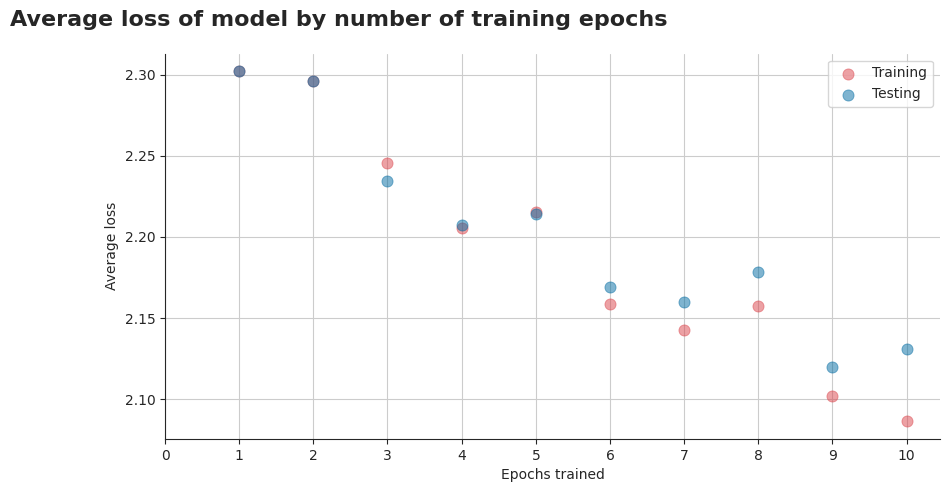

In [17]:
# Plot average loss per training epoch in training and testing data

# Set seaborn style
sns.set_style('whitegrid')

# Define color mapping
color_map = {'red': '#DB444B',
             'blue': '#006BA2', 
             'green': '#379A8B',
             'magenta': '#D23EBC', 
             'cyan': '#3EBCD2', 
             'yellow': '#EBB434', 
             'purple': '#9A607F',
             'olive': '#B4BA39',  
             'gold': '#D1B07C', 
             'gray': '#758D99', 
            }

sns.set_style('ticks')
fig, ax = plt.subplots(1, figsize=(10,5))
sns.scatterplot(x=epochs, y=train_losses, color=color_map['red'], label="Training", alpha=0.5, edgecolor=None, s=64, zorder=3)
sns.scatterplot(x=epochs, y=test_losses, color=color_map['blue'], label="Testing", alpha=0.5, edgecolor=None, s=64, zorder=3)
ax.set_title("Average loss of model by number of training epochs", weight='bold', fontsize=16, loc='left', pad=20, x=-0.2)
ax.set_xlabel("Epochs trained")
ax.set_ylabel("Average loss")
ax.locator_params(axis='y', nbins=6)
ax.set_xticks(np.linspace(0, 10, 11).astype(int))
ax.grid()
ax.spines[['right','top']].set_visible(False)
ax.legend();

/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/opt/conda/lib/python3.10/site-packages/numpy/lib/arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)


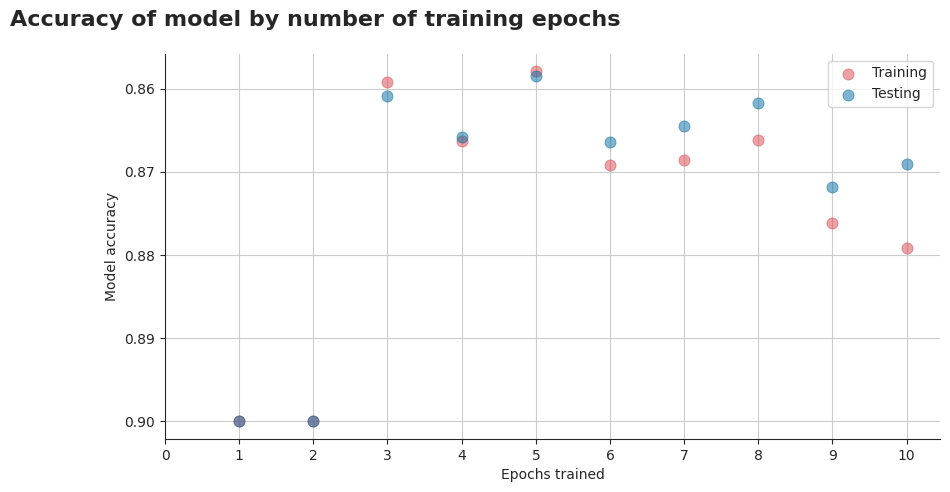

In [18]:
# Plot model accuracy in training and testing data

sns.set_style('ticks')
fig, ax = plt.subplots(1, figsize=(10,5))
sns.scatterplot(x=epochs, y=train_accuracy, color=color_map['red'], label="Training", alpha=0.5, edgecolor=None, s=64, zorder=3)
sns.scatterplot(x=epochs, y=test_accuracy, color=color_map['blue'], label="Testing", alpha=0.5, edgecolor=None, s=64, zorder=3)
ax.set_title("Accuracy of model by number of training epochs", weight='bold', fontsize=16, loc='left', pad=20, x=-0.2)
ax.set_xlabel("Epochs trained")
ax.set_ylabel("Model accuracy")
ax.locator_params(axis='y', nbins=6)
#ax.set_ylim([0.99999,1.00001])
ax.set_xticks(np.linspace(0, 10, 11).astype(int))
ax.grid()
ax.spines[['right','top']].set_visible(False)
ax.legend();